In [20]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Setting dataset directory

In [21]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir+'/Pepper/')
print(dataset_dir)

c:\Users\aryaj\OneDrive\Desktop\project 6\final_code\Pepper


### Setting some global variables

In [22]:
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 10

In [23]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True) 

Found 2475 files belonging to 2 classes.


In [24]:
class_name = dataset.class_names
class_name

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [25]:
len(dataset)
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Some sample images

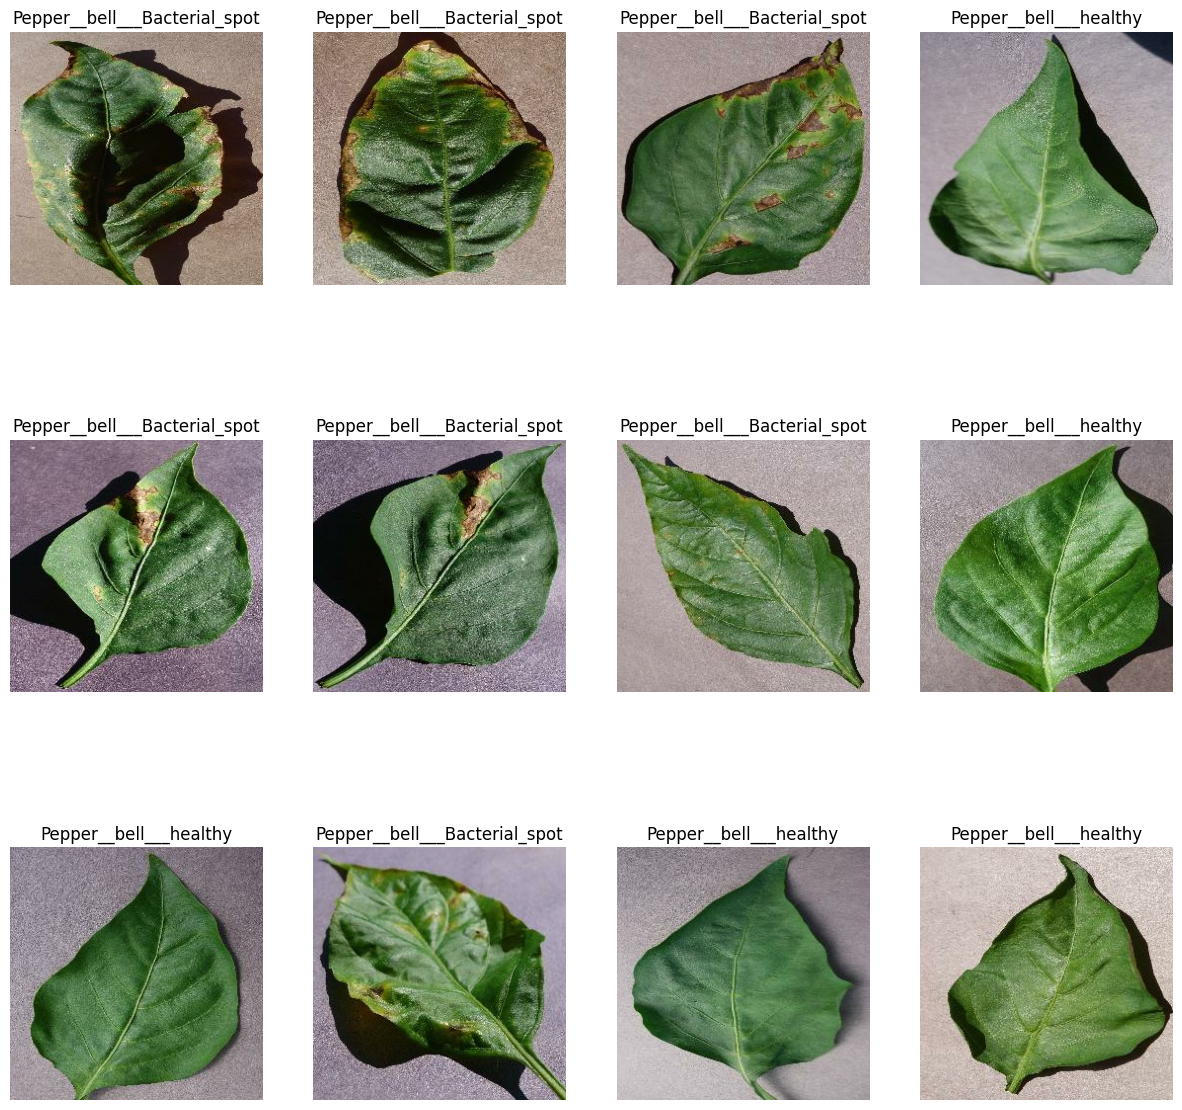

In [26]:
plt.figure(figsize = (15,15))
for image, label in dataset.take(1): 
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis("off")

### Splitting the dataset

In [27]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [28]:
train_data, val_data, test_data = split_dataset(dataset)

In [29]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :78 
Batch size of Training Data is :62
Batch size of Validation Data is :7 
Batch size of Testing Data is :9 


In [30]:
train_ds = train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

### Image preprocessing functions

In [31]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_Size, Image_Size),
    layers.Rescaling(1.0/255)
])

In [32]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor = 0.5)
])

### Model Definition

In [33]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),
])


model.build(input_shape = input_shape)

In [34]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 64)               │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,176 (1.32 MB)

 Trainable params: 346,176 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation

In [35]:
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

### Model Training

In [36]:
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 721ms/step - accuracy: 0.4738 - loss: 1.7062 - val_accuracy: 0.6830 - val_loss: 0.6474
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 48s 749ms/step - accuracy: 0.6639 - loss: 0.6193 - val_accuracy: 0.6250 - val_loss: 0.6766
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 747ms/step - accuracy: 0.7973 - loss: 0.4620 - val_accuracy: 0.8036 - val_loss: 0.5297
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - accuracy: 0.8803 - loss: 0.3171 - val_accuracy: 0.9420 - val_loss: 0.1687
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 771ms/step - accuracy: 0.9503 - loss: 0.1525 - val_accuracy: 0.9643 - val_loss: 0.0883
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 702ms/step - accuracy: 0.9718 - loss: 0.1394 - val_accuracy: 0.9688 - val_loss: 0.0694
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 712ms/step - accuracy: 0.9744 - loss: 0.0717 - val_accuracy: 0.9688 - val_loss: 0.0831
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 706ms/step - accuracy: 0.9951 - loss: 0.0499 - val_accu

### Model Evaluation

In [37]:
scores = model.evaluate(train_data)
print(scores)

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9958 - loss: 0.0212
[0.01873156987130642, 0.996943473815918]


In [38]:
history
history.params
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### Saving model for any future use

In [39]:
model.save('pepper_model.keras')

### Analyzing the Output

In [40]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

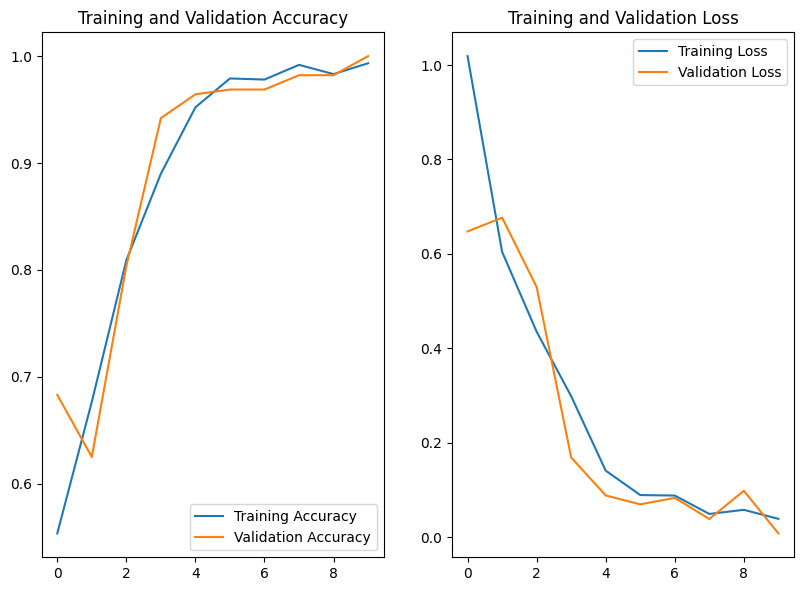

In [41]:
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(Epochs), train_acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(Epochs), train_loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

### Making predictions using the model

First Image of batch to predict :
Actual label :  Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Predicted label :  Pepper__bell___healthy
<class 'tensorflow.python.framework.ops.EagerTensor'>


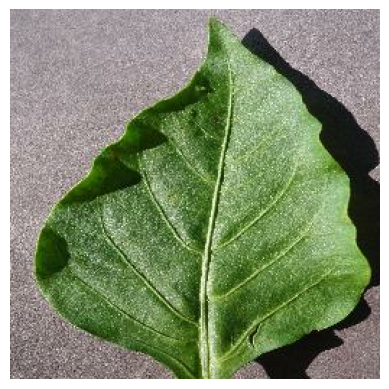

In [44]:
for batch_image, batch_label in test_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')
    print(type(batch_image))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


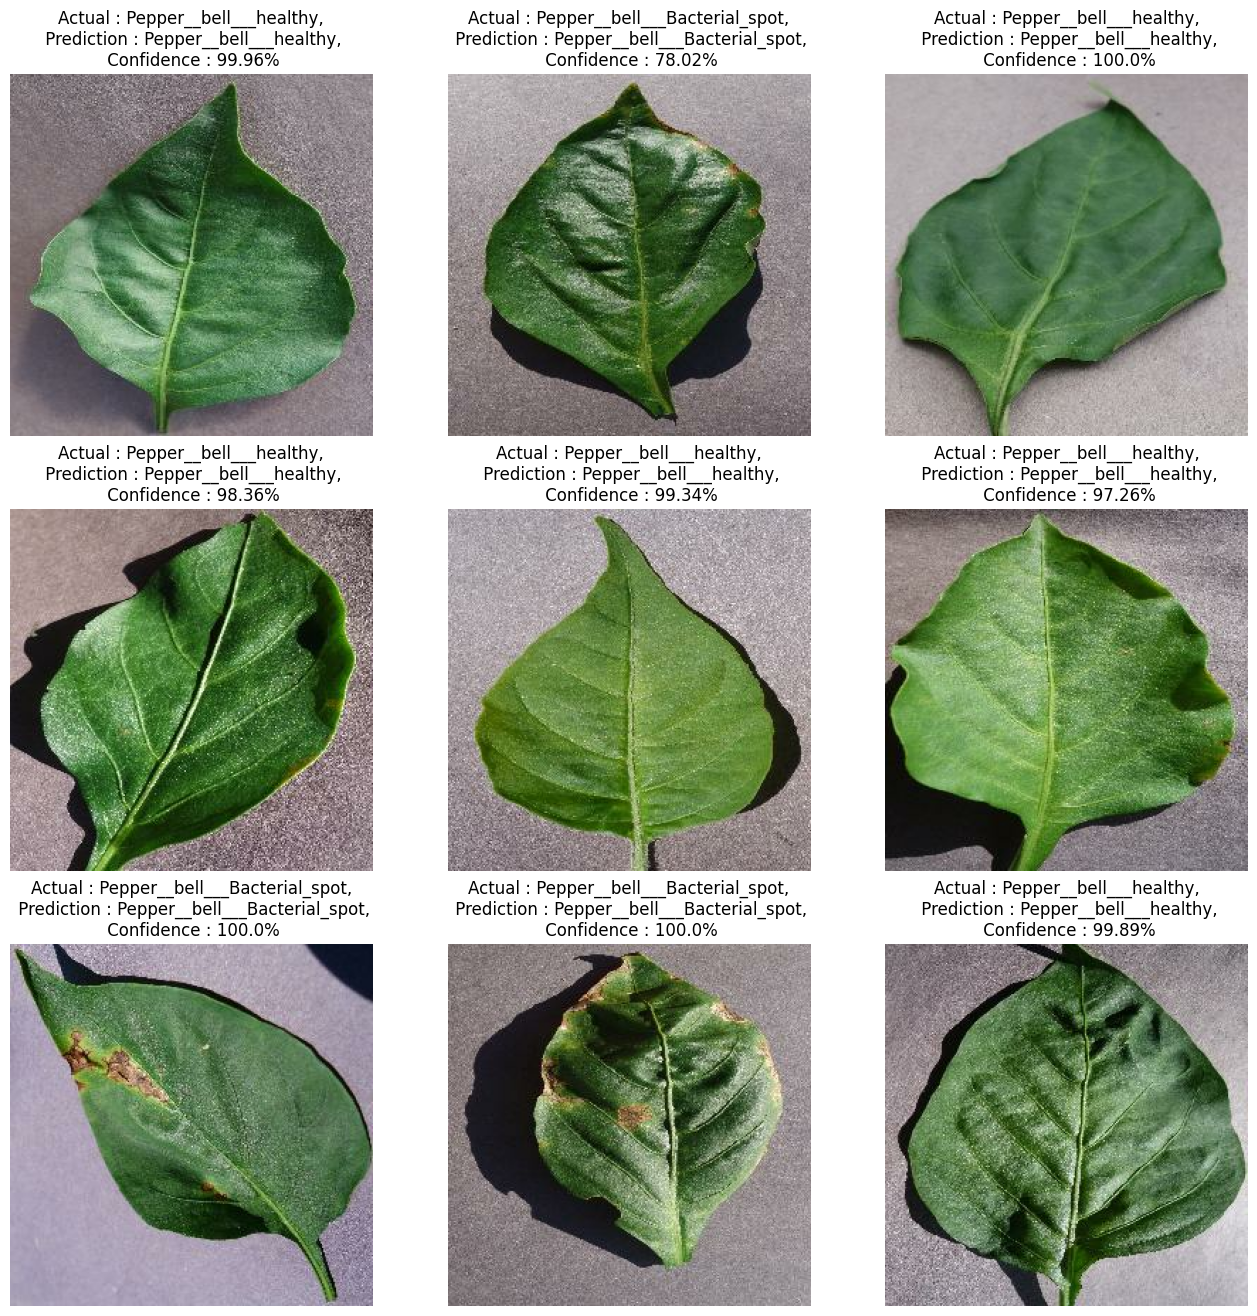

In [43]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

Current_Dir = os.getcwd()
dataset_dir = pathlib.Path('C:/Users/aryaj/OneDrive/Desktop/project 6/final_code/Datasets/Pepper/')
print(dataset_dir)
Image_Size = 256
Batch_Size = 32
Channels = 3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True) 
class_name = dataset.class_names
class_name
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_data, val_data, test_data = split_dataset(dataset)
model = tf.keras.models.load_model('C:/Users/aryaj/OneDrive/Desktop/project 6/final_code/models/pepper_model.keras')
true_labels = []
predicted_labels = []


for batch_image, batch_label in test_data:
    true_labels.extend(batch_label.numpy()) 
    batch_prediction = model.predict(batch_image)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))


conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(conf_matrix)



C:\Users\aryaj\OneDrive\Desktop\project 6\final_code\Datasets\Pepper
Found 2475 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
[[126   0]
 [  1 161]]


In [9]:
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (precision * recall) / (precision + recall)
gm = (recall * specificity) ** 0.5
fpr = 1 - specificity

print("Accuracy:", round(accuracy,6))
print("Precision:", precision)
print("Recall:", round(recall,6))
print("Specificity:", specificity)
print("F1 Score:", round(f1_score,6))
print("Geometric Mean:", round(gm,6))
print("False Positive Rate:", round(fpr,6))

Accuracy: 0.996528
Precision: 1.0
Recall: 0.993827
Specificity: 1.0
F1 Score: 0.996904
Geometric Mean: 0.996909
False Positive Rate: 0.0
